In [11]:
"""
信号特征与肌力水平可视化
"""
import scipy.io as sio
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

In [12]:
"""
original version feature calculation method
rebuild in iFEMG_feature.py
"""
class SignalFeature():
    '1.init original signal. 2.signal segment'
    # signal basic parameters
    rest_original_signal = []   # original signal in 1 row []
    active_original_signal = [] # original signal in 1 row []
    fs = 0

    rest_signal_len = 0     # original signal length
    active_signal_len = 0   # original signal length
    # data segment list, 2D list
    # initiate in signal_segment function
    rest_signal_segment = []
    active_signal_segment = []
    # init function
    def __init__(self, rest_signal, active_signal, sample_freq):
        # input signal: 1D list []
        self.rest_original_signal = rest_signal
        self.active_original_signal = active_signal
        self.fs = sample_freq

        self.rest_signal_len = len(rest_signal)
        self.active_signal_len = len(active_signal)
        pass
    # signal split function
    def signal_segment(self, window_len, step_len):
        'split active/rest signal using sliding window'
        # reset segment list
        self.rest_signal_segment = []
        self.active_signal_segment = []
        # split rest signal
        if self.rest_signal_len < window_len:
            print("Rest signal length is below the window length")
            self.rest_signal_segment.append(self.rest_original_signal)
        else:
            for i in range((self.rest_signal_len - window_len)//step_len + 1):
                self.rest_signal_segment.append(self.rest_original_signal[i*step_len : i*step_len + window_len])
                pass
            pass

        # split active signal
        if self.active_signal_len < window_len:
            print("active signal length is below the window length")
            self.active_signal_segment.append(self.active_original_signal)
        else:
            for i in range((self.active_signal_len - window_len)//step_len + 1):
                self.active_signal_segment.append(self.active_original_signal[i*step_len : i*step_len + window_len])
                pass
            pass
    pass


class FMGFeature(SignalFeature):
    def __init__(self, rest_signal, active_signal, sample_freq):
        super().__init__(rest_signal, active_signal, sample_freq)
        pass

    def rest_mean(self):
        result_list = []
        for i in self.rest_signal_segment:
            result_list.append(sum(i)/len(i))
            pass
        return result_list
    
    def active_mean(self):
        result_list = []
        for i in self.active_signal_segment:
            result_list.append(sum(i)/len(i))
            pass
        return result_list

    def FMG_increase(self):
        'calculate FMG increase: (active - rest) / rest'
        result_list = []
        # calculate average FMG value in rest segment
        rest_mean_FMG = sum(self.rest_original_signal) / self.rest_signal_len
        # calculate results
        for i in self.active_signal_segment:
            result_list.append((sum(i)/len(i) - rest_mean_FMG)/rest_mean_FMG)
            pass
        return result_list
    pass


class sEMGFeature(SignalFeature):
    def __init__(self, rest_signal, active_signal, sample_freq):
        super().__init__(rest_signal, active_signal, sample_freq)
        pass

    def time_features(self):
        # calculate average absolute value of rest sEMG
        result_list = []
        rest_mean_sEMG = sum([abs(i) for i in self.rest_original_signal])/self.rest_signal_len
        for i in self.active_signal_segment:
            result_list.append((sum([abs(num) for num in i])/len(i) - rest_mean_sEMG)/rest_mean_sEMG)
        return result_list

    def freq_features(self):
        result_list = []
        for data in self.active_signal_segment:
            # calculate psd specture
            pxx, f = plt.psd(data, NFFT = 256, Fs = self.fs, Fc = 0, detrend = mlab.detrend_none,
                            window = mlab.window_hanning, noverlap = 0, pad_to = None, 
                            sides = 'default', scale_by_freq = None, return_line = None)
            plt.close()
            '''
            scipy.signal.welch(x, fs=1.0, window='hann', nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
            '''
            # med frequency
            N = len(f)
            # calculate (psd curve) integration
            MSUM = [0]
            for i in range(1, N, 1):
                MSUM.append(MSUM[i - 1] + pxx[i - 1] * (f[i] - f[i - 1]))
            
            diff = []
            for i in range(0, N, 1):
                diff.append(MSUM[i] - MSUM[N-1]/2)
            for i in range(N):
                if diff[i] <= 0 and diff[i + 1] >= 0:
                    mf_x1= i
                    mf_x2 = i + 1
                    break
            # linear interpolation based mf calculation
            mf = (f[mf_x1]*diff[mf_x2] - f[mf_x2]*diff[mf_x1])/(diff[mf_x2] - diff[mf_x1])
            
            # average power frequency
            FSUM = [0]
            for i in range(1, N, 1):
                FSUM.append(FSUM[i - 1] + f[i] * pxx[i - 1] * (f[i] - f[i - 1]))
            mpf = FSUM[N - 1]/MSUM[N - 1]
            # power = FSUM[N - 1]
            # power_time = sum([num*num for num in data])
            result_list.append([mf, mpf])
            pass
        return result_list
    pass


# feature dataframe normalization function
def fea_df_norm(features_df, *col_name):
    #temp_series = []
    fea_norm_df = features_df
    for name in col_name:
        # 对feature_df 中的 col_name列进行归一化
        s = (features_df[name] - features_df[name].min())/(features_df[name].max() - features_df[name].min())
        #安全删除，如果用del是永久删除
        fea_norm_df = fea_norm_df.drop([name], axis = 1)
        fea_norm_df[name] = s
    return fea_norm_df

In [26]:
# load all experimental data in signal_df 
# file path format: 'D:\\folder path\\subject name\\label_(rest/active).mat'
file_folder_path = 'D:\code\data\iFEMG_data_set'
subjects = ['\zpk1', '\zpk2', '\zpk3', '\zpk4', '\zpk5', '\zpk6']
mat_name = ['d0', 'd2', 'd5', 'd7', 'dm']

signal_df = pd.DataFrame(columns = ('subject_name', 'rest_signal', 'active_signal', 'label', 'sensor_channel'))
# rest/active signal: [:, 0]FMG, [:, 1]sEMG

for i in subjects:
    for j in mat_name:
        # print('processing: ', i + j)
        # build data frame, every row has a unique label
        signal_df = signal_df.append({'subject_name' : i,
                                    'rest_signal': sio.loadmat(file_folder_path + i + '\\' + j + '_rest.mat')[j + '_rest'],
                                    'active_signal': sio.loadmat(file_folder_path + i + '\\' + j + '_active.mat')[j + '_active'], 
                                    'label' : j,
                                    'sensor_channel' : 'bicps_br'}, ignore_index=True)
    pass

In [27]:
'''
1st index: subjects
2nd index: force level
3rd index: sensor channel
FMG + sEMG + ultrasound
'''
# init a dataframe to store features
# 计算feature dataframe
sb_feature_df =pd.DataFrame(columns=('subject_name', 'label', 'FMG_increase', 'sEMG_increase', 'mean_freq', 'mean_power_freq'))

# 使用boolean值索引出某一名受试者的实验数据
sb_data = signal_df.loc[signal_df.loc[:, 'subject_name'] == '\zpk2']
# 计算一名被试的所有特征
for row in sb_data.itertuples():
    FMG = FMGFeature(row.rest_signal[:, 0], row.active_signal[:, 0], 1223)
    sEMG = sEMGFeature(row.rest_signal[:, 1], row.active_signal[:, 1], 1223)
    FMG.signal_segment(2446, 500)
    sEMG.signal_segment(2446, 500)
    # print(row.label)
    temp_FMG_fea = FMG.FMG_increase()
    temp_sEMG_freq_fea = sEMG.freq_features()
    temp_sEMG_time_fea = sEMG.time_features()
    temp_len = len(temp_FMG_fea)
    for i in range(temp_len):
        sb_feature_df = sb_feature_df.append({'subject_name': row.subject_name,
                                            'label': row.label,
                                            'FMG_increase': temp_FMG_fea[i],
                                            'sEMG_increase': temp_sEMG_time_fea[i],
                                            'mean_freq': temp_sEMG_freq_fea[i][0],
                                            'mean_power_freq': temp_sEMG_freq_fea[i][1]}, ignore_index=True)
        pass
    pass

sb_fea_norm_df = fea_df_norm(sb_feature_df, 'FMG_increase', 'sEMG_increase', 'mean_freq', 'mean_power_freq')

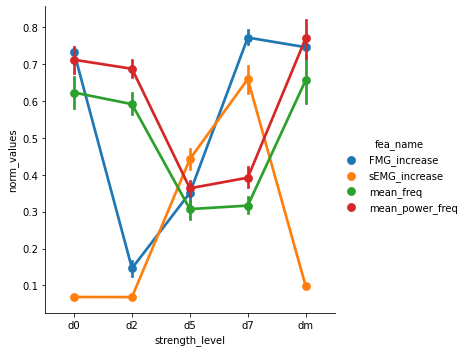

In [29]:
# show figure
show_df = pd.DataFrame(columns = ('subject', 'strength_level', 'norm_values', 'fea_name'))

for row in sb_fea_norm_df.itertuples():    # go through each row
    for i in ['FMG_increase', 'sEMG_increase', 'mean_freq', 'mean_power_freq']:
        show_df = show_df.append({'subject': row.subject_name,
                                'strength_level': row.label,
                                'norm_values': getattr(row, i),
                                'fea_name': i}, ignore_index=True)

sns.catplot(x = "strength_level",
            y = "norm_values",
            hue = "fea_name",
            data = show_df,
            kind = 'point')

In [30]:
sb_feature_df

,subject_name,label,FMG_increase,sEMG_increase,mean_freq,mean_power_freq
0,\zpk2,d0,0.159299,6.398762,62.188778,74.175500
1,\zpk2,d0,0.160886,6.002197,65.836718,78.244123
2,\zpk2,d0,0.162515,5.956600,65.940013,77.933626
3,\zpk2,d0,0.164277,5.876706,66.907428,79.257399
4,\zpk2,d0,0.165751,5.535029,63.137892,76.308365
...,...,...,...,...,...,...
323,\zpk2,dm,0.164280,5.907624,65.204376,75.753710
324,\zpk2,dm,0.164244,5.681641,61.616589,74.004283
325,\zpk2,dm,0.164119,5.909231,49.650719,68.788170
326,\zpk2,dm,0.163786,5.945128,50.515684,67.808847


In [31]:
sb_fea_norm_df

,subject_name,label,FMG_increase,sEMG_increase,mean_freq,mean_power_freq
0,\zpk2,d0,0.688746,0.114793,0.683274,0.733168
1,\zpk2,d0,0.705925,0.097044,0.788991,0.868194
2,\zpk2,d0,0.723554,0.095003,0.791985,0.857889
3,\zpk2,d0,0.742631,0.091427,0.820020,0.901821
4,\zpk2,d0,0.758587,0.076135,0.710780,0.803952
...,...,...,...,...,...,...
323,\zpk2,dm,0.742657,0.092811,0.770666,0.785544
324,\zpk2,dm,0.742271,0.082697,0.666692,0.727486
325,\zpk2,dm,0.740920,0.092883,0.319923,0.554379
326,\zpk2,dm,0.737319,0.094490,0.344989,0.521878


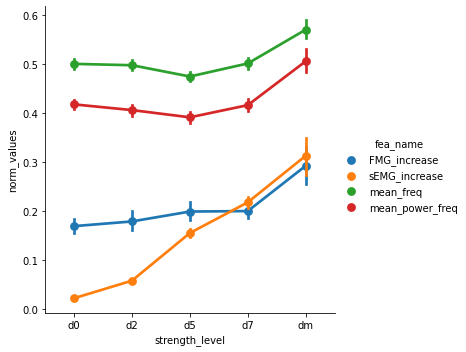

In [32]:
# 处理所有数据
all_feature_df =pd.DataFrame(columns=('subject_name', 'label', 'FMG_increase', 'sEMG_increase', 'mean_freq', 'mean_power_freq'))

for row in signal_df.itertuples():
    FMG = FMGFeature(row.rest_signal[:, 0], row.active_signal[:, 0], 1223)
    sEMG = sEMGFeature(row.rest_signal[:, 1], row.active_signal[:, 1], 1223)
    FMG.signal_segment(1223, 500)
    sEMG.signal_segment(1223, 500)
    # print(row.label)
    temp_FMG_fea = FMG.FMG_increase()
    temp_sEMG_freq_fea = sEMG.freq_features()
    temp_sEMG_time_fea = sEMG.time_features()
    temp_len = len(temp_FMG_fea)
    for i in range(temp_len):
        all_feature_df = all_feature_df.append({'subject_name': row.subject_name,
                                            'label': row.label,
                                            'FMG_increase': temp_FMG_fea[i],
                                            'sEMG_increase': temp_sEMG_time_fea[i],
                                            'mean_freq': temp_sEMG_freq_fea[i][0],
                                            'mean_power_freq': temp_sEMG_freq_fea[i][1]}, ignore_index=True)
        pass
    pass
# normalization
all_fea_norm_df = fea_df_norm(all_feature_df, 'FMG_increase', 'sEMG_increase', 'mean_freq', 'mean_power_freq')

# show figure
show_df = pd.DataFrame(columns = ('subject', 'strength_level', 'norm_values', 'fea_name'))

for row in all_fea_norm_df.itertuples():    # go through each row
    for i in ['FMG_increase', 'sEMG_increase', 'mean_freq', 'mean_power_freq']:
        show_df = show_df.append({'subject': row.subject_name,
                                'strength_level': row.label,
                                'norm_values': getattr(row, i),
                                'fea_name': i}, ignore_index=True)

sns.catplot(x = "strength_level",
            y = "norm_values",
            hue = "fea_name",
            data = show_df,
            kind = 'point')